# Machine learning Energy power consumption

The dataset is exhaustive in its demonstration of energy consumption of the Tétouan city in Morocco. The distribution network is powered by 3 Zone stations, namely: Quads, Smir and Boussafou.

The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by 9 feature columns.




# Environment

In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pygam import s,ExpectileGAM
from plotnine import * 
from xgboost import XGBRegressor as xgb
color_pal=sns.color_palette()
from sklearn.model_selection import GridSearchCV


# Data description

The data contains 10 years worth of electricity demand from Paris



In [168]:
dataset = pd.read_csv('./PJMW_hourly.csv')

# Cleaning and ordering of data

In [169]:
dataset['Datetime']=pd.to_datetime(dataset['Datetime'])
dataset=dataset.set_index(['Datetime'])

# Graphing Data

<Axes: title={'center': 'Energy usage from PMJW'}, xlabel='Datetime'>

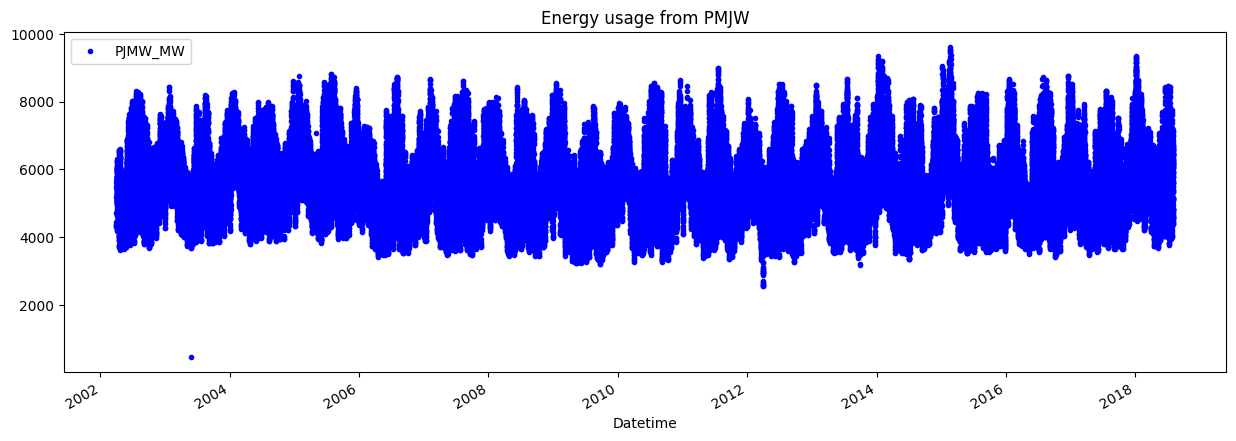

In [170]:

dataset.plot(style='.',figsize=(15,5),color=["blue"],title='Energy usage from PMJW')


# Train/Test data

In [171]:
dataset.columns

Index(['PJMW_MW'], dtype='object')

In [172]:
dataset=dataset.loc[dataset['PJMW_MW']>3250]

In [173]:
dataset[dataset['PJMW_MW'].isna()]
dataset['PJMW_MW'].isna().sum()

mask=dataset.index>='2015-01-01'
data_test=dataset.loc[mask]
data_train=dataset.loc[~mask]

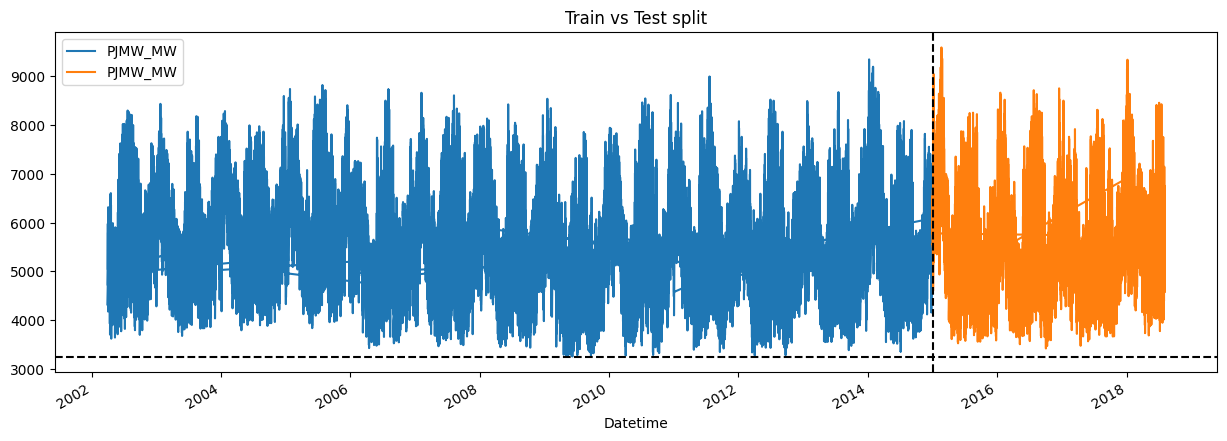

In [174]:
fig,ax=plt.subplots(figsize=(15,5))
data_train.plot(ax=ax,label='Training Set')
data_test.plot(ax=ax,label='Test Set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.axhline(3250,color='black',ls='--')
plt.title('Train vs Test split')
plt.show()

In [175]:
def create_feature(dataset):
    dataset=dataset.copy()
    dataset['HOUR']=dataset.index.hour
    dataset['MONTH']=dataset.index.month
    dataset['season'] = dataset['MONTH'] % 12 // 3 + 1
    dataset['DAY_OF_WEEK']=dataset.index.dayofweek
    dataset['DAY_OF_MONTH']=dataset.index.day
    dataset['QUARTER']=dataset.index.quarter
    dataset['BUSINESS_HOURS']=(dataset.index.hour >= 9) & (dataset.index.hour < 17)
    dataset['IS_PEAK_HOUR'] = dataset['HOUR'].isin([8, 12, 18]).astype(int)
    dataset['YEAR']=dataset.index.year
    return dataset
dataset=create_feature(dataset)

In [176]:
target_map=dataset['PJMW_MW'].to_dict()

In [177]:
def lag_maker(dataset):
    dataset['lag1']=(dataset.index-pd.Timedelta('364 days')).map(target_map)
    dataset['lag2']=(dataset.index-pd.Timedelta('364 days')).map(target_map)
    dataset['lag3']=(dataset.index-pd.Timedelta('364 days')).map(target_map)
    return dataset
dataset=lag_maker(dataset)

In [178]:
dataset

,PJMW_MW,HOUR,MONTH,season,DAY_OF_WEEK,DAY_OF_MONTH,QUARTER,BUSINESS_HOURS,IS_PEAK_HOUR,YEAR,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2002-12-31 01:00:00,5077.0,1,12,1,1,31,4,False,0,2002,NaN,NaN,NaN
2002-12-31 02:00:00,4939.0,2,12,1,1,31,4,False,0,2002,NaN,NaN,NaN
2002-12-31 03:00:00,4885.0,3,12,1,1,31,4,False,0,2002,NaN,NaN,NaN
2002-12-31 04:00:00,4857.0,4,12,1,1,31,4,False,0,2002,NaN,NaN,NaN
2002-12-31 05:00:00,4930.0,5,12,1,1,31,4,False,0,2002,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,8401.0,20,1,1,0,1,1,False,0,2018,6091.0,6091.0,6091.0
2018-01-01 21:00:00,8373.0,21,1,1,0,1,1,False,0,2018,5951.0,5951.0,5951.0
2018-01-01 22:00:00,8238.0,22,1,1,0,1,1,False,0,2018,5726.0,5726.0,5726.0


In [179]:
data_test=create_feature(data_test)
data_train=create_feature(data_train)

data_test=lag_maker(data_test)
data_train=lag_maker(data_train)

## Week consumption

In [180]:
dataset=dataset.sort_index()

## usage by hour

<Axes: xlabel='HOUR', ylabel='PJMW_MW'>

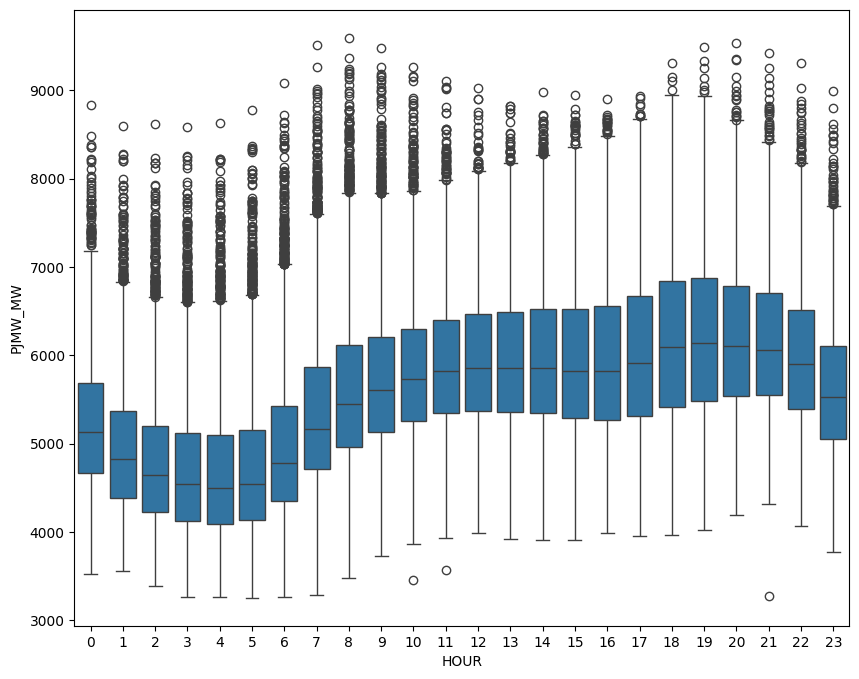

In [181]:
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(dataset,x="HOUR",y="PJMW_MW")


## Usage by Month

<Axes: xlabel='MONTH', ylabel='PJMW_MW'>

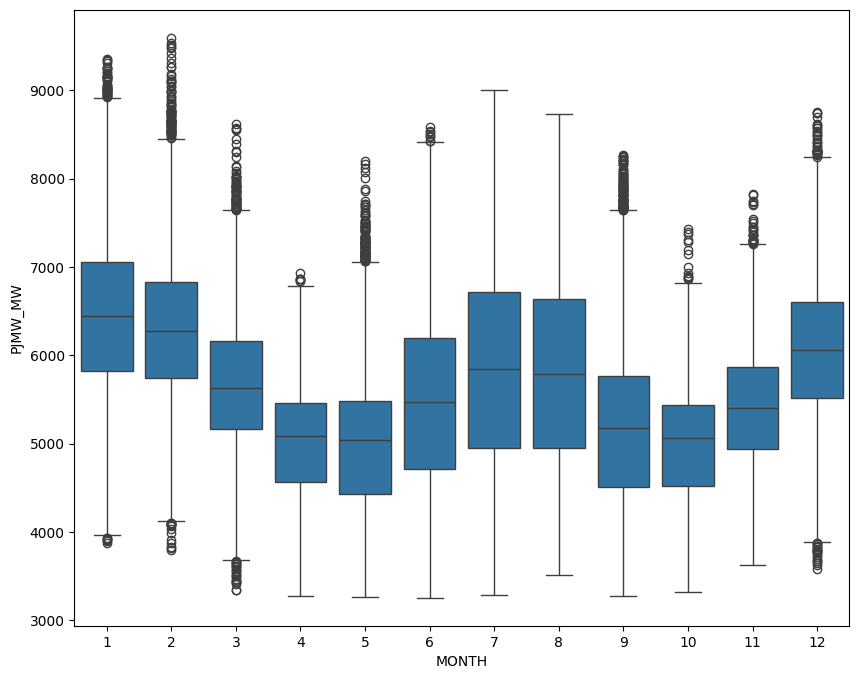

In [182]:
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(dataset,x="MONTH",y="PJMW_MW")

# Usage by week

<Axes: xlabel='Datetime'>

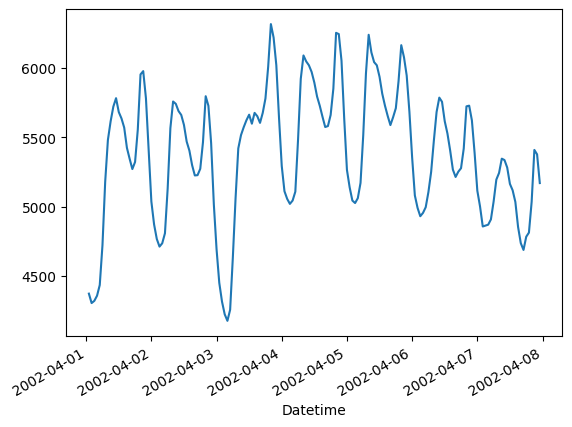

In [183]:
week_ex=dataset.loc[(dataset.index>'2002-04-01') & (dataset.index<'2002-04-08')] 
fig,ax=plt.subplots()
week_ex['PJMW_MW'].plot(ax=ax)

# Make Model

In [184]:
features=['HOUR','MONTH','season','DAY_OF_WEEK','DAY_OF_MONTH','QUARTER','BUSINESS_HOURS','IS_PEAK_HOUR','YEAR','lag1','lag2','lag3']
target='PJMW_MW'


In [185]:
X_train=data_train[features]
Y_train=data_train[target]

X_test=data_test[features]
Y_test=data_test[target]

In [186]:
reg=xgb(n_estimatators=1000,early_stopping_round=50)
reg.fit(X_train,Y_train,
        eval_set=[(X_train,Y_train),(X_test,Y_test)]
        ,verbose=True)

[0]	validation_0-rmse:792.66999	validation_1-rmse:872.34965
[1]	validation_0-rmse:687.27342	validation_1-rmse:777.68279
[2]	validation_0-rmse:624.03603	validation_1-rmse:729.72261
[3]	validation_0-rmse:585.68587	validation_1-rmse:701.55552
[4]	validation_0-rmse:558.67536	validation_1-rmse:682.56590


C:\Users\As-Pro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [15:51:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "early_stopping_round", "n_estimatators" } are not used.



[5]	validation_0-rmse:540.33531	validation_1-rmse:673.68553
[6]	validation_0-rmse:526.25598	validation_1-rmse:665.41516
[7]	validation_0-rmse:512.39762	validation_1-rmse:668.94200
[8]	validation_0-rmse:505.54353	validation_1-rmse:666.95389
[9]	validation_0-rmse:500.20728	validation_1-rmse:665.42456
[10]	validation_0-rmse:486.80768	validation_1-rmse:667.02525
[11]	validation_0-rmse:480.18833	validation_1-rmse:666.39900
[12]	validation_0-rmse:469.12489	validation_1-rmse:666.20792
[13]	validation_0-rmse:459.41998	validation_1-rmse:670.36852
[14]	validation_0-rmse:456.87717	validation_1-rmse:671.70112
[15]	validation_0-rmse:452.97562	validation_1-rmse:676.80418
[16]	validation_0-rmse:450.62879	validation_1-rmse:675.83095
[17]	validation_0-rmse:443.85679	validation_1-rmse:677.62003
[18]	validation_0-rmse:438.03012	validation_1-rmse:677.80509
[19]	validation_0-rmse:435.83098	validation_1-rmse:679.86540
[20]	validation_0-rmse:434.11228	validation_1-rmse:677.82592
[21]	validation_0-rmse:426.69

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_round=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimatators=1000, n_estimators=None, ...)

<Axes: title={'center': 'feature_importance'}>

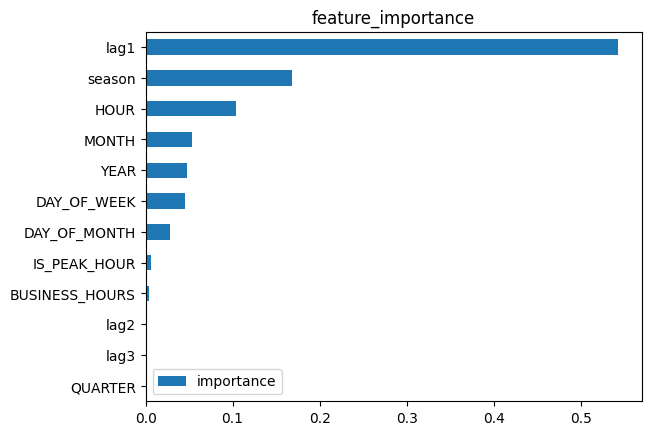

In [187]:
feat=pd.DataFrame(reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
feat.sort_values('importance').plot(kind='barh',title='feature_importance')

In [188]:
data_test['prediction']=reg.predict(X_test)

In [189]:
dataset=dataset.merge(data_test['prediction'],how='left',left_index=True,right_index=True)

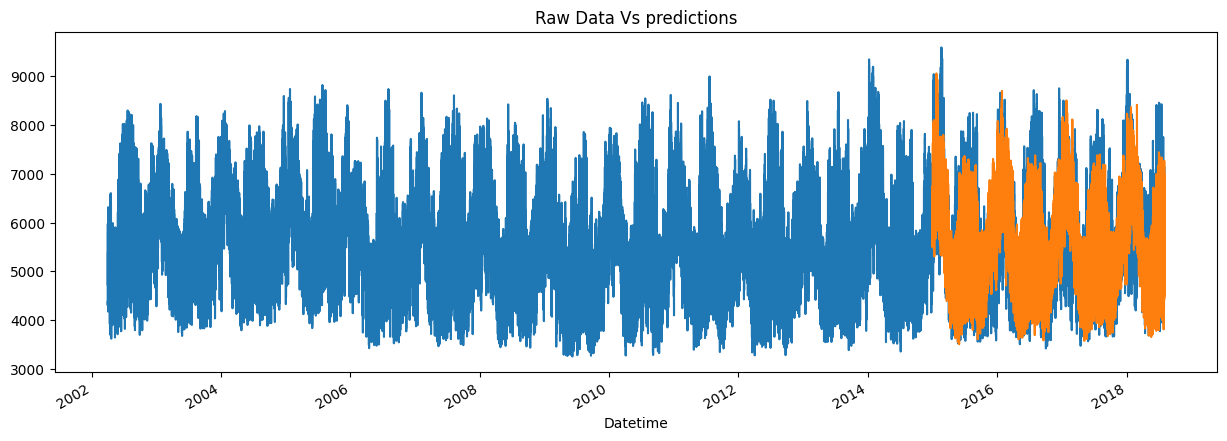

In [190]:
fig,ax=plt.subplots(figsize=(15,5))
dataset['PJMW_MW'].plot(ax=ax,label='Actual')
dataset['prediction'].plot(ax=ax,label='prediction')
plt.title('Raw Data Vs predictions')
plt.show()

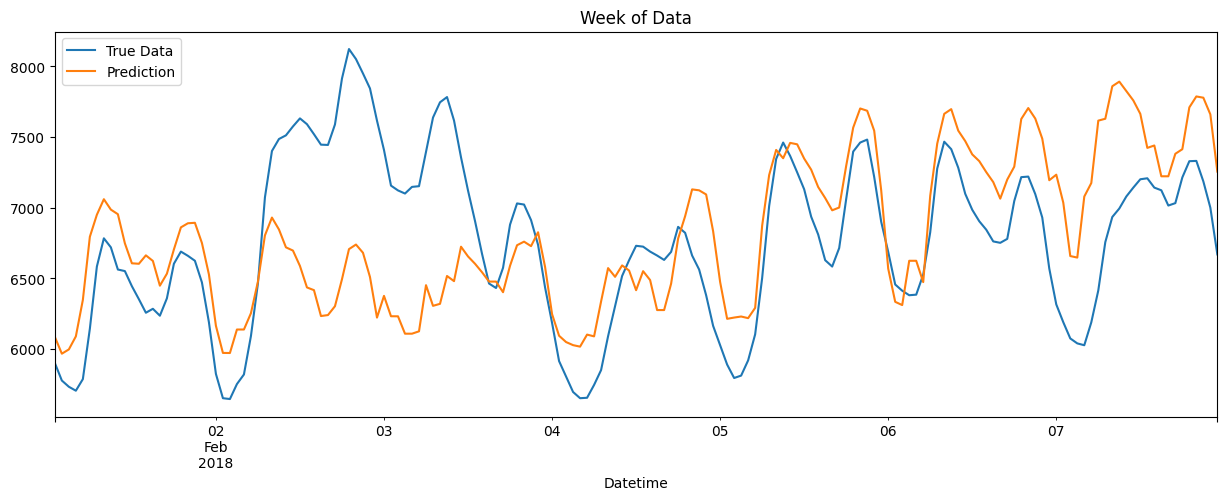

In [191]:
ax=dataset.loc[(dataset.index>'2018-02-01') & (dataset.index<'2018-02-08')]['PJMW_MW'].plot(figsize=(15,5),title='Week of Data')
dataset.loc[(dataset.index>'2018-02-01') & (dataset.index<'2018-02-08')]['prediction'].plot(style='-')

plt.legend(['True Data','Prediction'])
plt.show()

In [192]:
score=np.sqrt(mean_squared_error(data_test['PJMW_MW'],data_test['prediction']))
print(score)

706.2831981312512
